# Generate datasets for TSP.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from pathlib import Path

from modules.helper_functions_tsp import(find_problem_size, convert_integer_to_binary_list,
read_file_name, validate_distance_array, cost_fn_fact, convert_bit_string_to_cycle)

from modules.graph_functions import (plot_shortest_routes)

from modules.config import DATA_SOURCES

In [2]:
LOCATIONS = 8
GRID_SIZE = 100
DATA_TARGET = 'networks'
SAVE_DATA = True
READ_DATA = True


In [3]:
filename1 = f'sim_dist_{LOCATIONS}_locs.txt'
filename2 = f'sim_points_{LOCATIONS}_locs.txt'
filepath1 = Path(DATA_TARGET).joinpath(filename1)
filepath2 = Path(DATA_TARGET).joinpath(filename2)

Generate random position

In [4]:
np.random.seed(42)
points = np.random.uniform(0, GRID_SIZE, size=(LOCATIONS,2))
#print(points)

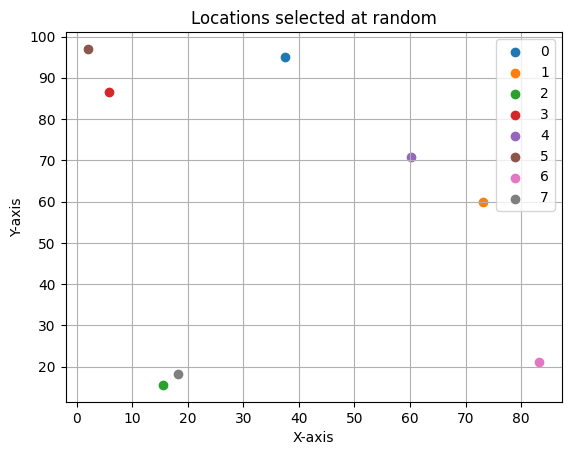

In [5]:
for i in range(LOCATIONS):
    plt.scatter(points[i, 0], points[i, 1], marker='o', label=i)

# Adding title and labels for clarity
plt.legend()
plt.title('Locations selected at random')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.grid(True)
plt.show()

In [6]:
def find_distance(points: np.array, point1:int, point2:int)->float:
    x1 = points[point1, 0]
    y1 = points[point1, 1]
    x2 = points[point2, 0]
    y2 = points[point2, 1]
    dist = math.sqrt((x1 - x2)**2 + (y1 - y2)**2)
    return round(dist, 1)

In [7]:
def write_data(list: list, filepath: str):
    """Open a file in write mode"""
    if SAVE_DATA:
        with open(filepath, 'w') as file:
            for rows in list:
                line = ''
                for i, item in enumerate(rows):
                    #print(f'item = {item})
                    line += str(item)
                    if i < len(rows):
                        line += '\t'
                file.write(line + '\n')

        print(f'Data has been written to {filepath}')
    else:
        print('SAVE_DATA is not set')

In [8]:
distances = []
for i in range(LOCATIONS):
  distance_row = []
  for j in range(LOCATIONS):
    distance_row.append(str(find_distance(points, i, j)))
  distances.append(distance_row)

#print(distances)
write_data(distances, filepath1)


Data has been written to networks\sim_dist_8_locs.txt


In [9]:
points_list = points.tolist()
write_data(points_list, filepath2)
#print(points_list)

Data has been written to networks\sim_points_8_locs.txt


In [10]:
if READ_DATA:
    data_filename = read_file_name(LOCATIONS, DATA_SOURCES)
    best_dist = DATA_SOURCES[LOCATIONS]['best']
    print(f'Distance data will be read from filename {data_filename}.  It is known that the shortest distance is {best_dist}.')
    distance_array = np.genfromtxt(data_filename)
    validate_distance_array(distance_array, LOCATIONS)

    points_filename = read_file_name(LOCATIONS, DATA_SOURCES, file_type='points')
    print(f'The co-ordinates of locations will be read from {points_filename}')
    points = np.genfromtxt(points_filename)

Reading distance data
Distance data will be read from filename networks/sim_dist_8_locs.txt.  It is known that the shortest distance is 277.2.
Reading co-ordinate data
The co-ordinates of locations will be read from networks/sim_points_8_locs.txt


In [11]:
qubits = find_problem_size(LOCATIONS, 'original')
print(f'There are {qubits} qubits needed for {LOCATIONS} locations in the orig formulation.')

There are 14 qubits needed for 8 locations in the orig formulation.


In [ ]:
cost_fn = cost_fn_fact(LOCATIONS, distance_array)
lowest_to_date = LOCATIONS*2 * 100 #to high
for integer in range(2**qubits):
    binary_string_list = convert_integer_to_binary_list(integer, length=qubits, gray=False)
    cost = cost_fn(binary_string_list)
    if cost < lowest_to_date:
        lowest_to_date = cost
        route_string = binary_string_list

In [ ]:
route1 = convert_bit_string_to_cycle(route_string, LOCATIONS)
print(f'The lowest distance found by a brute force search is {lowest_to_date} with route list = {route1}')
route2 = [0, 4, 1, 6, 7, 2, 3, 5]

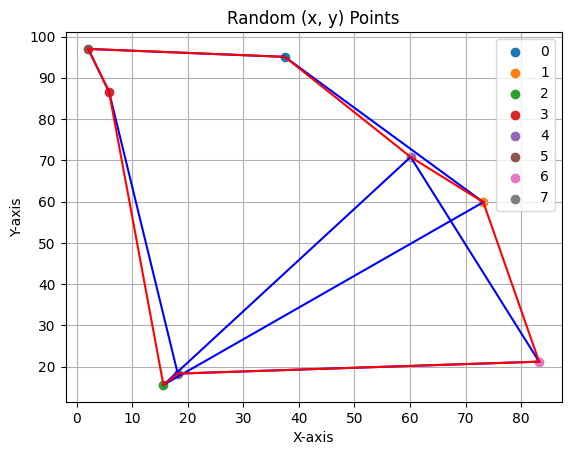

In [14]:
plot_shortest_routes(points, route1, route2)